# 고양이 스티커 부착하기
## 1. 필요 모듈 임포트

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 2. 이미지 경로 설정 및 이미지 전처리

### 이미지를 가져와 사용할 준비를 한다. opencv 특징 상 BGR 색상계 사용하므로 사진 색이 변경될 수 있다. 따라서 cv2.cvtColor() 메서드를 통해 다시 RGB 색상계를  이용한 이미지로 변경해준다.

<Before preprocessing>


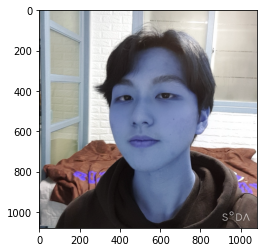

<After preprocessing>


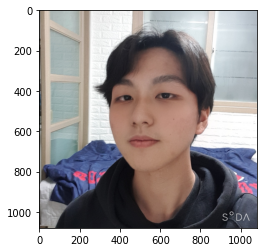

In [3]:
#이미지 경로설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_3.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr_orig = img_bgr.copy() # 투명도 작업용 변수


img_show = img_bgr.copy() #출력용 이미지는 따로 보관함.


print("<Before preprocessing>")
plt.imshow(img_bgr)
plt.show()

##이미지 색상 보정처리
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_bgr_rot = img_rgb.copy() # 회전 작업용 변수
img_dark = img_rgb.copy() # 어두운 사진 작업용 변수
img_far = img_rgb.copy() # 얼굴 작게 나온 사진 작업용 변수

print("<After preprocessing>")
plt.imshow(img_rgb)
plt.show()

## 3. 얼굴 위치  검출기 생성

### 오브젝트  디텍션 기술을  이용해 얼굴의 위치를 찾는다.

### 이미지에서 각 위치마다의 색상 변화량을 HOG를 통해 파악하고 SVM 선형분류기를 이용해 벡터화 시킨다. 이후 sliding window 기법을 이용해 작은 영역을 조금씩 이동해겨며 얼굴을 파악해 정사각형을 그린다.

### 얼굴 탐지기는 dlib의 hog detector를 이용해 구현했다.

<Face detection rsult>


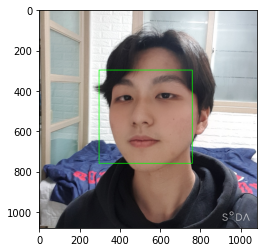

In [4]:
# HOG 얼굴 바운딩박스 탐지기 생성 및 할당
detector_hog = dlib.get_frontal_face_detector()

#얼굴 바운딩박스 추출 - 얼굴 검출기를 이미지에 적용
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# 이미지 피라미드? - 이미지를 upsampling해서 크기를 키우는 것
# 작게 촬영된 얼굴을 크게 보게 만드는것 - 정확한 검출 가능


# 찾은 얼굴 영역 좌표 
for dlib_rect in dlib_rects: 
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
print("<Face detection rsult>")
plt.imshow(img_show_rgb)
plt.show()

## 4. 얼굴 랜드마크 데이터 불러오기

### Object keypoint estimation 알고리즘을 이용해 객체 내부의 점을 찾는다. 이번 프로젝트에서는 top-down형식으로, bounding box를 찾고 그 안에서 keypoint를 예측하는 형식으로 진행했다.

### 모델은 사전에 http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 에서 
### 다운받아 ~/aiffel/camera_sticker/models 내에 
### shape_predictor_68_face_landmarks.dat 의 이름으로 저장해 놓았다.

In [5]:
#얼굴 랜드마크 예측 모델 불러오기
#지정한 모델 불러오기
#landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

## 5. Bounding Box에서 Face landmark 찾아내기

68
[[(352, 467), (348, 516), (355, 567), (364, 619), (375, 671), (397, 718), (431, 756), (469, 788), (520, 799), (579, 790), (638, 766), (696, 735), (742, 694), (772, 644), (790, 585), (800, 524), (807, 461), (358, 396), (372, 363), (403, 346), (440, 345), (472, 360), (549, 354), (594, 334), (645, 331), (691, 348), (728, 381), (506, 420), (500, 455), (493, 489), (485, 524), (462, 570), (478, 576), (497, 580), (521, 575), (545, 569), (392, 444), (413, 428), (440, 426), (465, 442), (441, 447), (413, 450), (583, 434), (610, 417), (640, 417), (671, 430), (642, 438), (610, 438), (440, 653), (459, 632), (481, 618), (500, 625), (521, 617), (558, 631), (601, 649), (560, 669), (525, 679), (502, 681), (482, 679), (460, 671), (452, 652), (483, 646), (502, 648), (523, 646), (585, 649), (522, 646), (501, 649), (482, 646)]]


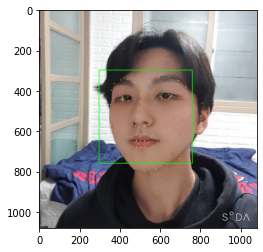

In [6]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
print(list_landmarks)

# 찾은 랜드마크 영상에 출력하기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 6. 코 위치 확인하기

### 해당 고양이 스티커는 코 부분에 위치할 것이므로 코의 좌표를 찾는다.

In [7]:
#코위치확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 데이터 셋 인덱스에서 코끝의 index는 33 입니다
    x = landmark[33][0]
    y = landmark[33][1] #- dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) #바운딩 박스 내 코끝 랜드마크의 좌표
    print ('(w,h) : (%d,%d)'%(w,h)) #바운딩 박스 크기

(497, 580)
(x,y) : (497,580)
(w,h) : (463,463)


## 7. 스티커 적용하기

### 스티커 이미지를 읽어서 적용 해 보았다.

In [8]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(463, 463, 3)


### 원본 이미지에 스티커 추가하기 위해 x,y 좌표 수정

In [9]:
refined_x = x // 2 #정 중앙에 위치
refined_y = y // 2  # 정 중앙에 위치
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (248,290)


### y축 좌표값에 발생하는 음수값 처리해주기
#### 여기서 음수는 바운딩 박스 바깥으로 나간 좌표값을 의미

In [10]:
#음수값 만큼 crop해주기
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#이미지 정 중앙에 삽입하므로 -값 발생 x

(x,y) : (248,290)


## 8. 원본이미지에 스티커 적용 

In [11]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
# 원본이미지img_show의 [] 내부에 해당하는 부분은 새로운 값을 재위치키라는 뜻

## 9. 스티커 결과이미지 출력(img_show로 출력)

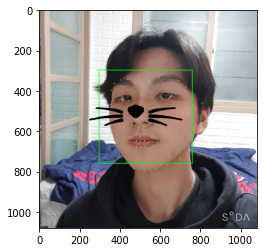

In [12]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

plt.show() #스티커 위치가 제대로 들어갔는지 확인

# 결과 이미지 출력(img_rgb로 출력)

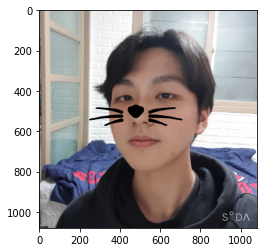

In [13]:
#바운딩 박스 및 랜드마크 제거
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 코드 수정요소

### 스티커 위치 변경
#### 스티커를 코 끝에 위치시키기 위하여 랜드마크 점을 옮겼다.
#### x = landmark[33][0], y = landmark[33][1]을 landmark[33][0], landmark[33][1]으로 바꿔주었다

#### 처음엔 임의로 스티커를 바운딩 박스 중앙에 위치시키기 위해 refined_y = (y // h) + 310 로 임의 설정해 맞췄다.

#### 그러다가, 정 중앙이니 x,y값을 모두 반으로 나눈 값으로 하면 되지 않을까 생각이 들었고, 
#### refined_x = x // 2 
#### refined_y = y // 2  
#### 로 x,y를 재정의 해서 돌려보니 정 중앙에 스티커를 위치시킬 수 있었다.

### png 배경 없애기
#### 코드 np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)의 의미를 몰라 찾아보았다.
#### 위 코드의 numpy.where 메소드는 img_sticker == 0(검정) 일 땐 img_sticker의 값을 취하고, 그렇지 않으면 sticker_area의 값을 취한다는 뜻이다.
#### 혹은 img_sitcker ==0은 두고 img_sticker랑 img_area 파라미터 순서를 바꿔줘도 된다. 이렇게 하면 이미지_sticker값을 취해 검은 부분만 가져온다.


# 예외처리

## 1. 반투명한 스티커 만들기

### cv2.addWeighted() 메서드 사용하기

cv2.addWeighted(src1, alpha, src2, beta, gamma, dst=None, dtype=None) -> dst

#### • src1: (입력) 첫 번째 사진
#### • alpha: 첫 번째 사진 가중치
#### • src2: 두 번째 사진. src1과 같은 크기 & 같은 타입
#### • beta: 두 번째 사진 가중치
#### • gamma: 결과 사진에 추가적으로 더할 값
#### • dst: 가중치 합 결과 영상
#### • dtype: 출력 사진(dst)의 타입

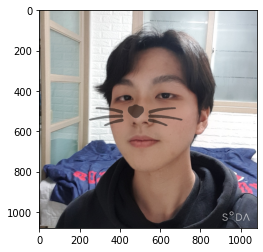

In [14]:
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


### 반투명 스티커 만들기 회고

#### 결괏값이 제대로 안 나와서 한참 헤맸던 것 같다. 이유는 모든 알고리즘을 다 구현했음에도 불구하고 계속 불투명한 스티커가 산출이 되서, 무엇이 문제인지 한참을 고민했다. 아무래도 코드가 위에서부터 진행되면서, 기존에 사용되던 변수에 할당된 값이 계속 상속되는 것 같다는  생각이 들었다. 이에 사진 경로도 새로 하나 더 만들어보고, 이미지 할당된 변수와 sticker_area 변수도 다 바꿔봤는데 계속 기존 값이 잔존했다. 
#### 어떻게 하면 이미지를 초기화를 시키지, 고민하다 생성자를 써야하나까지 생각했는데, 생각을 다시 해보니 이미 있는 데이터 위에 덮어 쓸 생각을 하지 말고, 애초에 처음 이미지를 받아올 때 .copy()변수로 변수 하나에 값을 더 할당해 놓으면 되는 거라는걸 깨달았다. 따라서 맨 위 모듈 임포트 부분 아래 이미지 경로를 받고, 변수를 하나 더 추가하여 이미지 데이터를 할당하고, 만들어 놓은 코드를 실행하니 정상적으로 작동했다. 위에서부터 순차적으로 진행되는 인터프리터언어의 특성 상, 알고리즘 진행 과정 중 그 위에 값을 덮어씌울 생각보단 애당초 시작할 때 여러 변수에 값을 할당해 놓는게 더 편하다는 것을 알게 되었다.

## 2. 회전된 이미지에 스티커 삽입해보기

### 이미지를 임의로 회전시켜 얼굴 랜드마크가 잘 삽입되는지 보자
### 이미지 회전에는 cv2.getRotationMatrix2D 메서드 사용

(540.0, 540.0)
<Face detection bounding box>


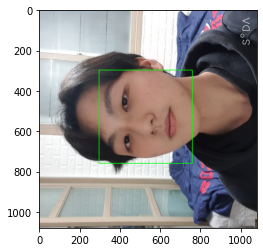

<Landmark result : Fail>


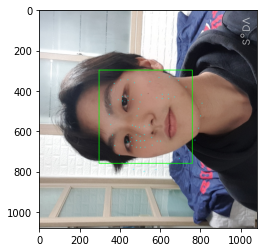

<Attatch sticker : Fail>


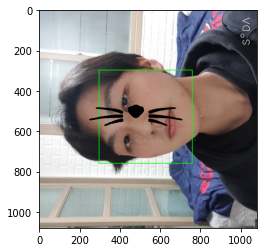

In [15]:
#새 이미지 기져오기 - 이미 RGB 변환 되어있는 이미지 
plt.imshow(img_bgr_rot)
plt.show

#이미지 회전시키기
width, height = img_bgr_rot.shape[:2] #(1080, 1080)
cp = (img_bgr_rot.shape[1] / 2, img_bgr_rot.shape[0] / 2) #회전 중심축 좌표 설정
print(cp)

img_rot = cv2.getRotationMatrix2D(cp, 90, 1) 
img_rot_dst = cv2.warpAffine(img_bgr_rot,img_rot,(width,height))


# plt.imshow(img_rot_dst)
# plt.show


#회전 이미지의 bounding box 확인
for dlib_rect in dlib_rects: 
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rot_dst, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

print("<Face detection bounding box>")
plt.imshow(img_rot_dst)
plt.show()

#회전 이미지의 랜드마크 확인

list_landmarks_rot = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks_rot.append(list_points)

# print(len(list_landmarks_rot[0]))
# print(list_landmarks_rot)

# 찾은 랜드마크 영상에 출력하기
for landmark in list_landmarks_rot:
    for point in landmark:
        cv2.circle(img_rot_dst, point, 2, (0, 255, 255), -1)
print("<Landmark result : Fail>")
plt.imshow(img_rot_dst)
plt.show()


#회전된 이미지에 스티커 삽입

sticker_area = img_rot_dst[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_rot_dst[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
(print("<Attatch sticker : Fail>"))
plt.imshow(img_rot_dst)
plt.show()

### 회전 이미지 조작 회고
#### 이미지를 회전시키기 위해 새로운 메서드를 가져다가 썼다. 투명도 조작보다 보다 직관적이라 이해하기 편했다. 회전을 시키고 랜드마크를 찍어보니 제대로 반영이 되지 않았다. 따라서 랜드마크 점 기준으로 부착되는 스티커도 자연히 모양이 틀어졌다. 이번 실습에 사용된 shape_predictor_68_face_landmarks 데이터셋이 회전 없는 정면방향의 사진이 아닌 다른 방향의 사진들에는 적합도가 떨어진다는 것을 알게 되었다. 
#### 보다 원활하게 적용되려면, 사진의 상하좌우 관계를 파악하여 랜드마크도 회전되어 적용되면 정확도가 훨씬 높아질 것 같다. 더 많은 개량이 필요한 모델이라고 생각이 들었다. shape_predictor_68_face_landmarks 모델과 더불어, 사진의 방향을 파악하는 알고리즘, 또는 사진을 정면방향 사진으로 전처리해주는 알고리즘 등을 병행해 사용하면 좋을 것 같다.

## 3. 어두운 사진에 스티커 붙이기

##### 사진의 밝기를 임의로 낮춘 후 스티커 붙이기 작업을 실시해 보자.

#### 밝기 정도를 다 다르게 하여 여러 장의 이미지를 만들고, 각각의 사진에 적용해 보았다.

#### 밝기 변화주기는 sub 함수를 사용했다.

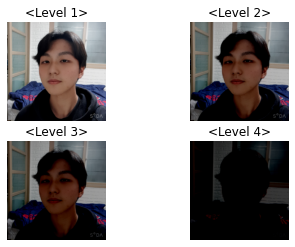

In [21]:
#어두운 사진불러오기
img_drk_1 = np.ones(img_dark.shape, dtype = "uint8") * 25
img_drk_2 = np.ones(img_dark.shape, dtype = "uint8") * 75
img_drk_3 = np.ones(img_dark.shape, dtype = "uint8") * 100
img_drk_4 = np.ones(img_dark.shape, dtype = "uint8") * 200

sub_1 = cv2.subtract(img_dark,img_drk_1)
sub_2 = cv2.subtract(img_dark,img_drk_2)
sub_3 = cv2.subtract(img_dark,img_drk_3)
sub_4 = cv2.subtract(img_dark,img_drk_4)

sub = [sub_1,sub_2,sub_3,sub_4]
sub_output = [sub_1,sub_2,sub_3,sub_4]

# plt.imshow(sub_1)
# plt.show()

for i in range(1,5):
    sub_image = sub[i-1]
    plt.subplot(2,2,i)
    plt.axis("off")
    plt.title(f"<Level {i}>")
    plt.imshow(sub_image)
    
# plt.subplot(1,4,1) #sublplot 모양 1x4 형태로 나열
# plt.axis('off') # 축없애기
# plt.imshow(sub_1) #이미지 산출



<Face detection bounding box>
<Face detection bounding box>
<Face detection bounding box>
<Face detection bounding box>


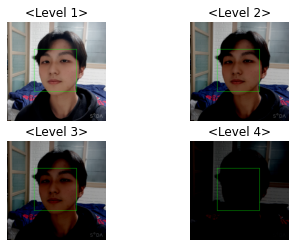

In [17]:
#회전 이미지의 bounding box 확인
for i in range(4):
    for dlib_rect in dlib_rects: 
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(sub[i], (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    print("<Face detection bounding box>")
    plt.subplot(2,2,i+1)
    plt.axis("off")
    plt.title(f"<Level {i+1}>")
    plt.imshow(sub[i])


#### 생각보다 이미지 명암에는 상관 없이 얼굴의 위치는 잘 인식했다. 인식이 잘 되는 이유를 생각 해 보자면, 어둡게 만들기 위해서 sub 메서드를 사용하여 모든 픽셀값에서 동일한 값을 빼주었는데, 이는 픽셀간 변화량에는 영향을 미치지 않기 때문에 HOG 방식이 여전히 잘 작동하는 것으로 사려된다.

### 랜드마크 확인

<Landmark result Level 1>


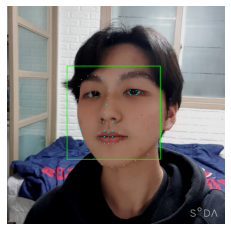

<Landmark result Level 2>


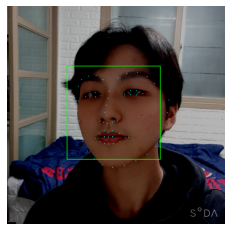

<Landmark result Level 3>


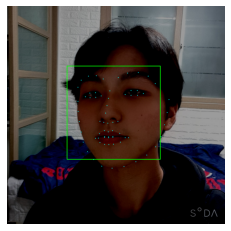

<Landmark result Level 4>


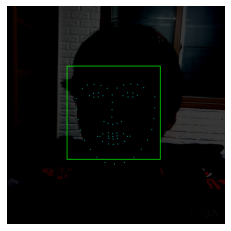

In [18]:
#회전 이미지의 랜드마크 확인
for i in range(4):
    list_landmarks_rot = []

    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    for dlib_rect in dlib_rects:
        points = landmark_predictor(sub[i], dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks_rot.append(list_points)

    # 찾은 랜드마크 영상에 출력하기
    for landmark in list_landmarks_rot:
        for point in landmark:
            cv2.circle(sub[i], point, 2, (0, 255, 255), -1)
        print(f"<Landmark result Level {i+1}>")
        plt.axis("off")
        plt.imshow(sub[i])
        plt.show()


#### 잘 보이지 않아서 크게 이미지를 뽑아봤다. 역시나 랜드마크 또한 인식이 잘 된다.

### 이미지에 스티커 부착하기

<Sticker result Level 1>


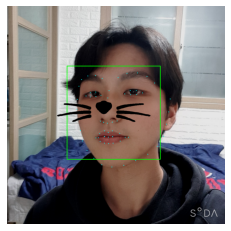

<Sticker result Level 2>


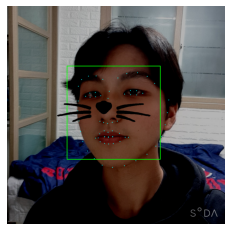

<Sticker result Level 3>


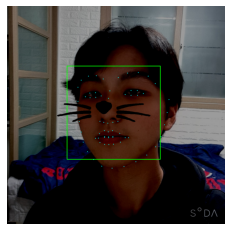

<Sticker result Level 4>


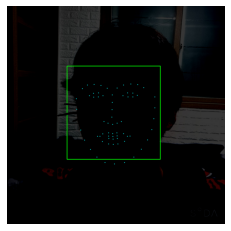

In [20]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식
for i in range(4):
    sticker_area = sub[i][refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    sub[i][refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
    # 원본이미지img_show의 [] 내부에 해당하는 부분은 새로운 값을 재위치키라는 뜻
    print(f"<Sticker result Level {i+1}>")
    plt.axis("off")
    plt.imshow(sub[i])
    plt.show()


Final Output


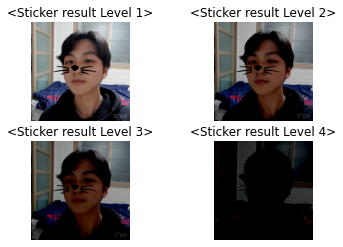

In [28]:
#Output
print("Final Output")
for i in range(4):
    sticker_area = sub_output[i][refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    sub_output[i][refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
    # 원본이미지img_show의 [] 내부에 해당하는 부분은 새로운 값을 재위치키라는 뜻
    
    plt.subplot(2,2,i+1)
    plt.title(f"<Sticker result Level {i+1}>")
    plt.axis("off")
    plt.imshow(sub_output[i])
    


### 느낀 점

#### 어둡게 찍은 사진이 아니라 임의로 어둡게 만들어서 결과를 산출했기때문에 이러한 결과가 나왔을 수도 있다고 생각이 든다. 실제로 어둡게 찍힌 이미지에서도 픽셀 변화량 관측이 잘 될지가 의문이 들었다. 

#### subplot을 이용하여 여러가지 이미지에 동시에 적용해 봤는데, 훨씬 가시적이고 결괏값을 파악하기 용이하다는 것을 깨달았다.  

## 4. 얼굴 작은 사진에 스티커 붙이기

<Face detection rsult : Fail>


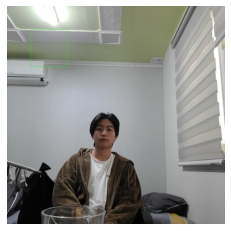

In [40]:
#이미지 경로설정 + 색상조정
my_image_path_tiny = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_4.png'
img_tin = cv2.imread(my_image_path_tiny)# OpenCV로 이미지를 불러옵니다
img_tiny = cv2.cvtColor(img_tin, cv2.COLOR_BGR2RGB)
# plt.imshow(img_tiny)

# 얼굴찾기
for dlib_rect in dlib_rects: 
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_tiny, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

# img_tiny =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
print("<Face detection rsult : Fail>")
plt.axis("off")
plt.imshow(img_tiny)
plt.show()

## 느낀점

#### 결과 = 실패 : 얼굴이 작게 나온 사진을  집어 넣어 시도해 봤는데 얼굴을 제대로 인식하지 못했다. 바운딩박스가 조명 근처에 생성된 것으로 보아, 본 사진은 조명 아래에서가 얼굴보다 변화량이 더 크기 때문이라고 판단이 들었다. 얼굴과 얼굴 주변의 픽셀값 변화량보다 다른 부분의 변화량이 더 크면 얼굴을 정상적으로 인식할 수 없다는 것을 알게 되었다. 이것이  HOG의 한계라고 생각한다. 

#### 시판되는 스노우나 스냅챗의 영상필터 같은 경우에도 카메라에서 멀리 있는 경우엔 잘 인식이 되지 않는데, 그 또한 이번 경우와 비슷한 경우라고 생각이 들었다.

#### 개선을 위해선 픽셀 변화량에 따라 랜드마크를 집는것에만 국한될 것이 아니라, 추가적인 인식 접근방식이 필요한 것으로 보인다.